<a href="https://colab.research.google.com/github/ramanakshay/Optimal-Transport/blob/main/notebooks/multi_marginal_ot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multi-Marginal Optimal Transport
1. Sinkhorn Solver
  * Generic Sinkhorn
  * Auto Sinkhorn
  * Random Sinkhorn
2. Multi-marginal Sinhorn on 1D Gaussian Distributions
  * Cost Tensor
  * Visualising the Coupling Tensor
3. Comparison of Running Times

## Multi-marginal Optimal Transport with Entropic Regularisation

Let $ n $ be the number of marginals and $ s $ be the size of 1D probability distributions.

The matrix $ A $ of size $ n \times s $ such that each row $ A_i $ is a 1D probability distribution of size $ s $.

$$ \sum_{j=0}^s{A_{ij}} = 1 \space \forall i \in ℕ_{n} \$$

The cost tensor $ C $ and coupling tensor $ P $ is a tensor of size $ s^n $. The optimal transport problem is defined as:

$$OT_C(A) := \min \left \langle  C,P\right \rangle + ɛH(P)$$

$H(P)$ is the discrete entropy for a coupling tensor with 3 marginals is defined as:

$$ H(P) := - \sum_{ijk}{P_{ijk}\left ( \log{P_{ijk} - 1} \right )} $$

## Import Libraries

In [1]:
!pip install pot  # Pip Installs Packages

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
user = 'ramanakshay'
repo = 'Optimal-Transport'

url = f"git+https://github.com/{user}/{repo}.git"
!pip install --upgrade {url}

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/ramanakshay/Optimal-Transport.git to /tmp/pip-req-build-yvlflgk7
  Running command git clone -q https://github.com/ramanakshay/Optimal-Transport.git /tmp/pip-req-build-yvlflgk7


In [3]:
import numpy as np 

import matplotlib.pyplot as plt # plotting

import ot  # ot
import ot.plot
from prettytable import PrettyTable

import time # measure time
from numpy import random

from tqdm import tqdm #progress bar
from IPython.display import clear_output

In [4]:
from utils.plot import plot_matrix,plot_2d_map
from utils.dist import find_cost_tensor

## Sinkhorn Solver Class

The scaling vectors are stored in a matrix $ U $ of size $ n \times s $. They can be initialised to ones or random values. Three versions of sinkhorn have been implemented:

1. **Generic Sinkhorn** \\
  Input: ɛ, n_iter, initialisation type \\
  Output: $P$ tensor \\
  Stopping Time: Number of Iterations (n_iter)

2. **Auto Sinkhorn** \\
  Input: ɛ, error, initialisation type \\
  Output: $P$ tensor \\
  Stopping Time:
  $ \left | \sum_{ℕ_{n} - \{i\}}{P - A_{i}} \right | \leq $ error $\space \forall i \in ℕ_{n} $

3. **Random Sinkhorn** \\
  Update k scaling vectors at a time. (faster Iteration but takes more time to converge) \\
  Input: ɛ, error, k,initialisation type \\
  Output: $P$ tensor \\
  Stopping Time:
  $ \left | \sum_{ℕ_{n} - \{i\}}{P - A_{i}} \right | \leq $ error $\space \forall i \in ℕ_{n} $

In [5]:
class SinkhornSolver(object):
  def __init__(self,A,C):
    self.A = A
    self.C = C
    self.n = A.shape[0]
    self.size = A.shape[1]
  
  def initialise(self,initial):
    if (initial == "ones"):
      return np.ones((self.n,self.size))
    elif (initial == "random"):
      return random.rand(self.n,self.size)
    else:
      raise ValueError("Invalid Argument: " + initial + " is not a valid type.")

#-----------------------------HELPER FUNCTIONS---------------------------------#
  def multiply(self,P,U,i):
    shape = [1]*self.n
    shape[i] = self.size
    shape = tuple(shape)
    temp = U[i].reshape(shape)
    return P * temp

  def divide(self,P,U,i):
    shape = [1]*self.n
    shape[i] = self.size
    shape = tuple(shape)
    temp = U[i].reshape(shape)
    return P / temp

  def sum_to_vector(self,P,i):
    axes = list(range(n))
    axes.remove(i)
    axes = tuple(axes)
    return np.sum(P,axis = axes)

#-----------------------------GENERIC SINKHORN---------------------------------#

  def generic_sinkhorn(self,epsilon,niter,initial = "ones"):
    U = self.initialise(initial)
    K = np.exp(-self.C/epsilon)
    P = np.copy(K)

    #initialise P
    for i in range(self.n):
      P = self.multiply(P,U,i)
    
    #loop
    for it in tqdm(range(niter)):
      for i in range(self.n):
        P = self.divide(P,U,i)
        U[i] = self.A[i] / self.sum_to_vector(P,i)
        P = self.multiply(P,U,i)
    
    #return coupling
    return P

#--------------------------------AUTO SINKHORN---------------------------------#

  def auto_sinkhorn(self,epsilon,error,initial = "ones"):
    U = self.initialise(initial)
    K = np.exp(-self.C/epsilon)
    P = np.copy(K)

    #initialise P
    for i in range(self.n):
      P = self.multiply(P,U,i)
    
    #loop
    iter = 0
    while(True):
      for i in range(self.n):
        P = self.divide(P,U,i)
        U[i] = self.A[i] / self.sum_to_vector(P,i)
        P = self.multiply(P,U,i)

      #marginal condition
      flag = True
      max_error = -1
      for i in range(self.n):
        if (np.any(abs(self.sum_to_vector(P,i) - self.A[i]) >= error)):
          flag = False
        clear_output(wait = True)
        max_error = max(max_error,np.max(abs(self.sum_to_vector(P,i) - self.A[i])))
      if(flag):
        break

      print("Maximum Error:",max_error)
      print("#Iterations:",iter)
      
      iter += 1

    #return coupling  
    return P

#--------------------------------RANDOM SINKHORN-------------------------------#

  def random_sinkhorn(self,epsilon,error,k = None,initial = "ones"):
    if (k == None):
      k = self.n

    U = self.initialise(initial)
    K = np.exp(-self.C/epsilon)
    P = np.copy(K)

    #initialise P
    for i in range(self.n):
      P = self.multiply(P,U,i)
    
    #loop
    iter = 0
    while(True):
      for i in random.choice(self.n, k, replace=False):
        P = self.divide(P,U,i)
        U[i] = self.A[i] / self.sum_to_vector(P,i)
        P = self.multiply(P,U,i)

      #marginal condition
      flag = True
      max_error = -1
      for i in range(self.n):
        if (np.any(abs(self.sum_to_vector(P,i) - self.A[i]) >= error)):
          flag = False
        clear_output(wait = True)
        max_error = max(max_error,np.max(abs(self.sum_to_vector(P,i) - self.A[i])))
      if(flag):
        break
      
      print("Maximum Error:",max_error)
      print("#Iterations:",iter)

      iter += 1

    #return coupling  
    return P

#------------------------------------------------------------------------------#

## Multi-marginal Sinkhorn on 1D Gaussian Distributions

### Gaussian Distribution

$$ f(x) = \frac{1}{\sigma \sqrt{2\pi}} e^{-\frac{1}{2}\left (  \frac{x-\mu}{\sigma}\right )^2} $$

where $\mu$ is the mean and $\sigma$ is the standard deviation of the distribution.

In [6]:
def gaussian_mix(n,mu,std,scale = None):
  assert len(mu) == len(std)
  if scale == None:
    scale = [1]*len(mu)
  x = np.arange(n, dtype = np.float64)
  h = 0
  for i in range(len(mu)):
    h += np.exp(-(x - mu[i]) ** 2 / (2 * std[i] ** 2))*scale[i]
  return h / h.sum()

In [7]:
n = 5
size = 50

A = np.empty((n,size), float)
# All marginals are the same
for i in range(n):
  A[i] = gaussian_mix(size,[25],[5],[1])


x = np.array([[i,] for i in range(size)]) # defining the space
X = np.tile(x.T,(n,1))

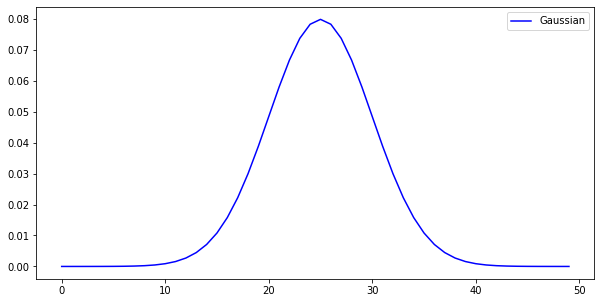

In [8]:
#Plot distributions
plt.figure(figsize=(10, 5))
plt.plot(x, A[0], 'b',label = 'Gaussian')
plt.legend()
plt.show()

### Cost Tensor

$$ C = \sum_{1 \leq i < j \leq n}{\frac {1}{\left | 1 + (r_i - r_j) \right | }} $$

(50, 50, 50, 50, 50)


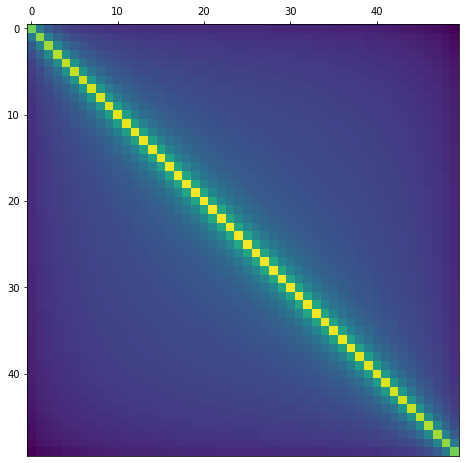

In [20]:
C = find_cost_tensor(X)
print(C.shape)
Cm = np.sum(C,axis = (2,3,4))
plot_matrix(Cm,x,x)

### Coupling Tensor

In [10]:
solver = SinkhornSolver(A,C)

In [14]:
P = solver.auto_sinkhorn(1e-2,1e-6,initial="random")

Maximum Error: 1.0073660973164422e-06
#Iterations: 167


In [19]:
#P = solver.random_sinkhorn(1e-3,1e-6,k = 3,initial="random")

In [11]:
#P = solver.generic_sinkhorn(10,100)

100%|██████████| 10/10 [01:06<00:00,  6.68s/it]


#### Coupling Projection Matrix

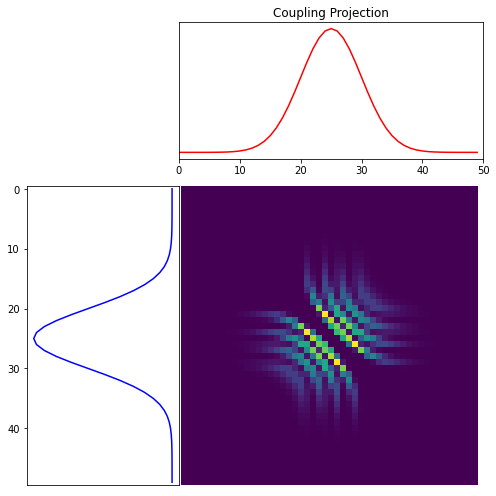

In [15]:
Pm = np.sum(P,axis = (2,3,4))

plt.figure(figsize=(7, 7))
ot.plot.plot1D_mat(A[0], A[1], Pm, 'Coupling Projection')

#### Comparing Approximate Distribution and Exact Distribution

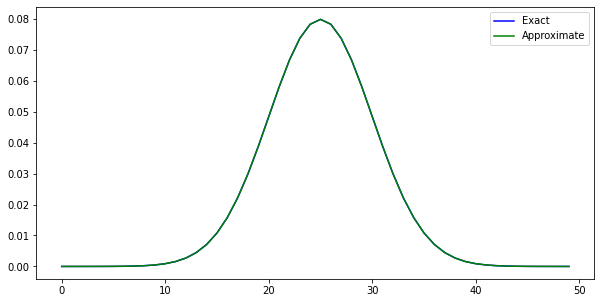

In [21]:
Pv = np.sum(P,axis = (1,2,3,4))
plt.figure(figsize=(10, 5))
plt.plot(x, A[0], 'b', label='Exact')
plt.plot(x, Pv, 'g', label='Approximate')
plt.legend()
plt.show()

#### 3D Plots

In [16]:
from mpl_toolkits import mplot3d

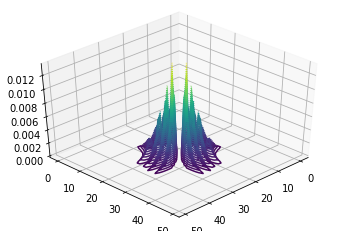

In [23]:
X, Y = np.meshgrid(x, x)

fig = plt.figure()
ax = plt.axes(projection='3d')

ax.contour3D(X, Y, Pm, 50)
clear_output()
ax.view_init(40, 45)

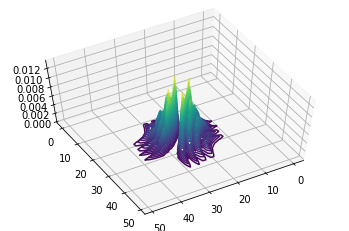

In [18]:
ax.view_init(60, 60)
fig

### OT Total Cost

In [22]:
OT = np.sum(C*P)
print('Total Cost:', OT)

Total Cost: 1.6452483634783885


## Comparison

In [ ]:
marginals = 5

table = PrettyTable()
table.field_names = ["Number of Marginals", "t(s)"]

for n in range(2,marginals+1):
  size = 50

  A = np.empty((n,size), float)
  for j in range(n):
    A[j] = gaussian_mix(size,[50],[10],[1])

  x = np.array([[i,] for i in range(size)]) # defining the space
  X = np.tile(x.T,(n,1))

  C = find_cost_tensor(X)

  solver = SinkhornSolver(A,C)

  start = time.time()
  P = solver.generic_sinkhorn(1e-2,100)
  end = time.time()
  t = end - start

  clear_output(wait = True)
  table.add_row([n,round(t,3)])

print(table)

100%|██████████| 100/100 [00:00<00:00, 27747.45it/s]


1 0.010150432586669922


100%|██████████| 100/100 [00:00<00:00, 11843.97it/s]


2 0.016318798065185547


100%|██████████| 100/100 [00:00<00:00, 708.61it/s]


3 0.15129566192626953


100%|██████████| 100/100 [00:07<00:00, 13.29it/s]


4 7.664548635482788


100%|██████████| 100/100 [06:49<00:00,  4.09s/it]

5 416.52280831336975
+---------------------+----------------------+
| Number of Marginals |         t(s)         |
+---------------------+----------------------+
|          1          | 0.010150432586669922 |
|          2          | 0.016318798065185547 |
|          3          | 0.15129566192626953  |
|          4          |  7.664548635482788   |
|          5          |  416.52280831336975  |
+---------------------+----------------------+
